Zespoły klasyfikatorów
----

In [ ]:
!git clone https://github.com/matzim95/ML-datasets


Cloning into 'ML-datasets'...
remote: Enumerating objects: 194, done.
remote: Counting objects: 100% (134/134), done.
remote: Compressing objects: 100% (110/110), done.
remote: Total 194 (delta 33), reused 124 (delta 24), pack-reused 60
Receiving objects: 100% (194/194), 35.45 MiB | 18.47 MiB/s, done.
Resolving deltas: 100% (45/45), done.


In [ ]:
import pandas as pd

def load_dataset(filename, class_column, index_col=None):
    dataset = pd.read_csv(f'ML-datasets/{filename}.csv', index_col=index_col)
    dataset['class'] = dataset[class_column].astype('category').cat.codes
    classes = dataset.pop(class_column).unique()
    return dataset, classes

def prepare_dataset(dataset_name):
    params = {'iris': {'class_column': 'species', 'index_col': None},
              'wine': {'class_column': 'Class', 'index_col': None},
              'glass': {'class_column': 'Type', 'index_col': 'ID'}}
    dataset, classes = load_dataset(dataset_name,
                                    **params[dataset_name])
    y = dataset.pop('class')
    X = dataset
    return X, y, classes

In [ ]:
X, y, classes = prepare_dataset('wine')

In [ ]:
X

,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735
...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,13.71,5.65,2.45,20.5,95,1.68,0.61,0.52,1.06,7.70,0.64,1.74,740
174,13.40,3.91,2.48,23.0,102,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750
175,13.27,4.28,2.26,20.0,120,1.59,0.69,0.43,1.35,10.20,0.59,1.56,835
176,13.17,2.59,2.37,20.0,120,1.65,0.68,0.53,1.46,9.30,0.60,1.62,840


Bagging
---

In [ ]:
from sklearn.ensemble import BaggingClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import Normalizer, StandardScaler


In [ ]:
normalizer = Normalizer()
standarizer = StandardScaler()
preprocessor = standarizer

## Testy na zbiorach danych

In [ ]:

def preprocess_data(X, preprocessor=None):
    if preprocessor is not None:
        preprocessor.fit(X)
        X_preprocessed = X.copy()
        X_preprocessed[:] = preprocessor.transform(X.values)
        X = X_preprocessed
    return X

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# average:
#   None - wyniki dla każdej klasy osobno
#   'binary' - dla wybranej w `pos_label` etykiety
#   'micro' - dla całkowitej liczby TP, FN, FP
#   'macro' - nieważona średnia dla każdej klasy
#   'weighted' - ważona średnia dla każdej klasy

def calculate_metrics(target, prediction, average='macro'):
    accuracy = accuracy_score(target, prediction)
    precision = precision_score(target, prediction, average=average)
    recall = recall_score(target, prediction, average=average)
    f1 = f1_score(target, prediction, average=average)
    mislabeled = (target != prediction).sum()
    total = len(target)
    return accuracy, precision, recall, f1, mislabeled, total

def print_results(metrics, classifier_id='classifier'):
    print(f'Results for {classifier_id}')
    print('----')
    print(f'  Accuracy:  {metrics[0]}')
    print(f'  Precision: {metrics[1]}')
    print(f'  Recall:    {metrics[2]}')
    print(f'  F1 score:  {metrics[3]}')
    print(f'  Mislabeled {metrics[4]} out of {metrics[5]}')
    print('\n')
    
def plot_confusion_matrix(confusion_matrix, classes, title=None,
                          title_appendix='',
                          cmap=plt.cm.Blues):
    # tytuł wykresu
    if title_appendix:
        title_appendix = f'({title_appendix})'
    if title is None:
        title = f'Confusion matrix {title_appendix}'
    
    fig, ax = plt.subplots()
    # rysuje CM
    img = ax.imshow(confusion_matrix, cmap=cmap)
    # dodaje pasek z boku
    ax.figure.colorbar(img, ax=ax)
    # dodatki do wykresu
    ax.set_xticks(np.arange(confusion_matrix.shape[1]))
    ax.set_xticklabels(classes, rotation=45, ha='right', rotation_mode='anchor')
    ax.set_yticks(np.arange(confusion_matrix.shape[0]))
    ax.set_yticklabels(classes, rotation=45, ha='right', rotation_mode='anchor')
    ax.set_title(title)
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')
    
    # etykiety
    fmt = '.2f' if confusion_matrix.dtype == 'float' else 'd'
    thresh = confusion_matrix.max() / 2
    for y, row in enumerate(confusion_matrix):
        for x, cell in enumerate(row):
            ax.text(x, y, format(cell, fmt),
                    ha='center', va='center',
                    color='white' if cell > thresh else 'black')
    fig.tight_layout()
    
    return ax

def normalize_confusion_matrix(confusion_matrix):
    return confusion_matrix.astype(
        'float') / confusion_matrix.sum(
        axis=1)[np.newaxis].T

In [ ]:
X, y, classes = prepare_dataset('wine')
X = preprocess_data(X, standarizer)
X.describe()

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"


,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
count,1.780000e+02,1.780000e+02,1.780000e+02,1.780000e+02,1.780000e+02,1.780000e+02,1.780000e+02,1.780000e+02,1.780000e+02,1.780000e+02,1.780000e+02,1.780000e+02,1.780000e+02
mean,-8.619821e-16,-8.357859e-17,-8.657245e-16,-1.160121e-16,-1.995907e-17,-2.972030e-16,-4.016762e-16,4.079134e-16,-1.699639e-16,-1.122697e-17,3.717376e-16,2.919013e-16,-7.484650e-18
std,1.002821e+00,1.002821e+00,1.002821e+00,1.002821e+00,1.002821e+00,1.002821e+00,1.002821e+00,1.002821e+00,1.002821e+00,1.002821e+00,1.002821e+00,1.002821e+00,1.002821e+00
min,-2.434235e+00,-1.432983e+00,-3.679162e+00,-2.671018e+00,-2.088255e+00,-2.107246e+00,-1.695971e+00,-1.868234e+00,-2.069034e+00,-1.634288e+00,-2.094732e+00,-1.895054e+00,-1.493188e+00
25%,-7.882448e-01,-6.587486e-01,-5.721225e-01,-6.891372e-01,-8.244151e-01,-8.854682e-01,-8.275393e-01,-7.401412e-01,-5.972835e-01,-7.951025e-01,-7.675624e-01,-9.522483e-01,-7.846378e-01
50%,6.099988e-02,-4.231120e-01,-2.382132e-02,1.518295e-03,-1.222817e-01,9.595986e-02,1.061497e-01,-1.760948e-01,-6.289785e-02,-1.592246e-01,3.312687e-02,2.377348e-01,-2.337204e-01
75%,8.361286e-01,6.697929e-01,6.981085e-01,6.020883e-01,5.096384e-01,8.089974e-01,8.490851e-01,6.095413e-01,6.291754e-01,4.939560e-01,7.131644e-01,7.885875e-01,7.582494e-01
max,2.259772e+00,3.109192e+00,3.156325e+00,3.154511e+00,4.371372e+00,2.539515e+00,3.062832e+00,2.402403e+00,3.485073e+00,3.435432e+00,3.301694e+00,1.960915e+00,2.971473e+00


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [ ]:
print(y.value_counts())
print(y_train.value_counts())
print(y_test.value_counts())

2    71
0    59
1    48
Name: class, dtype: int64
2    57
0    47
1    38
Name: class, dtype: int64
2    14
0    12
1    10
Name: class, dtype: int64


In [ ]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

In [ ]:
tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)
y_tree = tree.predict(X_test)

Results for Decision Tree
----
  Accuracy:  0.9166666666666666
  Precision: 0.923076923076923
  Recall:    0.9246031746031745
  F1 score:  0.9229629629629629
  Mislabeled 3 out of 36




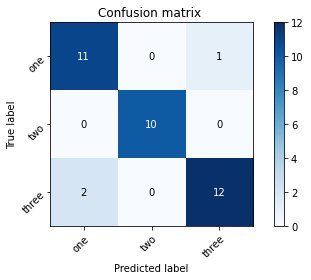

In [ ]:
print_results(calculate_metrics(y_test.values, y_tree), 'Decision Tree')
cm = confusion_matrix(y_test, y_tree)
plot_confusion_matrix(cm, classes)

In [ ]:
bclf = BaggingClassifier(base_estimator = GaussianNB(), n_estimators = 50)
bclf.fit(X_train, y_train)
y_b = bclf.predict(X_test)

Results for Bagging Ensemble
----
  Accuracy:  1.0
  Precision: 1.0
  Recall:    1.0
  F1 score:  1.0
  Mislabeled 0 out of 36




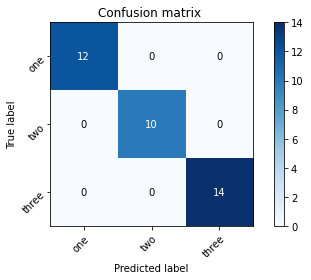

In [ ]:
print_results(calculate_metrics(y_test.values, y_b), 'Bagging Ensemble')
cm = confusion_matrix(y_test, y_b)
plot_confusion_matrix(cm, classes)

In [ ]:
print(bclf.estimators_)

[GaussianNB(), GaussianNB(), GaussianNB(), GaussianNB(), GaussianNB(), GaussianNB(), GaussianNB(), GaussianNB(), GaussianNB(), GaussianNB(), GaussianNB(), GaussianNB(), GaussianNB(), GaussianNB(), GaussianNB(), GaussianNB(), GaussianNB(), GaussianNB(), GaussianNB(), GaussianNB(), GaussianNB(), GaussianNB(), GaussianNB(), GaussianNB(), GaussianNB(), GaussianNB(), GaussianNB(), GaussianNB(), GaussianNB(), GaussianNB(), GaussianNB(), GaussianNB(), GaussianNB(), GaussianNB(), GaussianNB(), GaussianNB(), GaussianNB(), GaussianNB(), GaussianNB(), GaussianNB(), GaussianNB(), GaussianNB(), GaussianNB(), GaussianNB(), GaussianNB(), GaussianNB(), GaussianNB(), GaussianNB(), GaussianNB(), GaussianNB()]


In [ ]:
from sklearn.model_selection import KFold, StratifiedKFold

def cross_validate(classifier, kfold, X, y, classes, params=None, talk=True):
    if params is None:
        params = {}
    if classifier.__class__.__name__ == 'ABCMeta':
        clf = classifier(**params)
    else:
        clf = classifier
    predicted = []
    target = []

    for train_index, test_index in kfold.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        clf.fit(X=X_train, y=y_train)
        predicted = np.concatenate((predicted, clf.predict(X_test)))
        target = np.concatenate((target, y_test))
    
    metrics = calculate_metrics(target, predicted)
    cm = confusion_matrix(target, predicted)
    if talk:
        print_results(metrics, clf.__class__.__name__)
        plot_confusion_matrix(normalize_confusion_matrix(cm),
                              classes,
                              title_appendix=clf.__class__.__name__)
        plt.show()
    else:
        return metrics, cm

In [25]:
from sklearn.model_selection import cross_validate
cv_results = cross_validate(bclf, X, y, cv=10)
cv_results_tree = cross_validate(bclf, X, y, cv=10)

In [28]:
print(cv_results["test_score"])
print(cv_results_tree["test_score"])

[1.         1.         1.         0.94444444 0.94444444 1.
 1.         0.94444444 1.         1.        ]
[0.88888889 0.88888889 0.77777778 0.88888889 0.83333333 0.83333333
 1.         0.94444444 0.94117647 0.76470588]


In [34]:
cross_validate(DecisionTreeClassifier, StratifiedKFold(10), X, y, classes)

TypeError: ignored

In [30]:
cross_validate(BaggingClassifier, StratifiedKFold(10), X, y, classes)

TypeError: ignored

Random Forest
----

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rfclf = RandomForestClassifier()

rfclf.fit(X_train, y_train)

RandomForestClassifier()

In [ ]:
y_r = rfclf.predict(X_test)

In [ ]:
print(rfclf.estimators_)

[DecisionTreeClassifier(max_features='auto', random_state=863750795), DecisionTreeClassifier(max_features='auto', random_state=1564501245), DecisionTreeClassifier(max_features='auto', random_state=264293030), DecisionTreeClassifier(max_features='auto', random_state=1450473671), DecisionTreeClassifier(max_features='auto', random_state=1298062961), DecisionTreeClassifier(max_features='auto', random_state=1119617181), DecisionTreeClassifier(max_features='auto', random_state=1162892579), DecisionTreeClassifier(max_features='auto', random_state=1025498369), DecisionTreeClassifier(max_features='auto', random_state=146663017), DecisionTreeClassifier(max_features='auto', random_state=78636181), DecisionTreeClassifier(max_features='auto', random_state=872419691), DecisionTreeClassifier(max_features='auto', random_state=934536088), DecisionTreeClassifier(max_features='auto', random_state=851700103), DecisionTreeClassifier(max_features='auto', random_state=526167295), DecisionTreeClassifier(max_f

Results for RF Ensemble
----
  Accuracy:  1.0
  Precision: 1.0
  Recall:    1.0
  F1 score:  1.0
  Mislabeled 0 out of 36




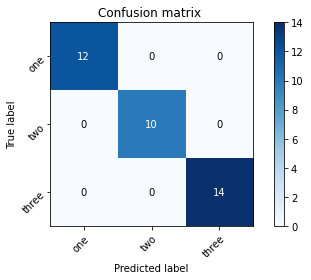

In [ ]:
print_results(calculate_metrics(y_test.values, y_r), 'RF Ensemble')
cm = confusion_matrix(y_test, y_r)
plot_confusion_matrix(cm, classes)

Results for RandomForestClassifier
----
  Accuracy:  0.9775280898876404
  Precision: 0.9761860312781462
  Recall:    0.9802657754436223
  F1 score:  0.9780237518736308
  Mislabeled 4 out of 178




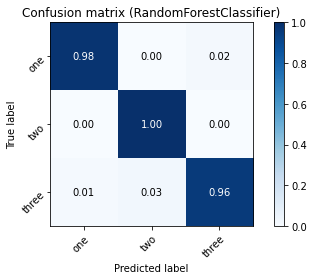

In [ ]:
cross_validate(RandomForestClassifier, StratifiedKFold(10), X, y, classes)

Ada Boost Classifier


In [ ]:
from sklearn.ensemble import AdaBoostClassifier
abclf = AdaBoostClassifier(n_estimators = 50)
abclf.fit(X_train, y_train)

AdaBoostClassifier()

In [ ]:
y_ab = abclf.predict(X_test)

Results for AdaBoost Ensemble
----
  Accuracy:  0.8888888888888888
  Precision: 0.9055555555555556
  Recall:    0.8952380952380952
  F1 score:  0.894137052031789
  Mislabeled 4 out of 36




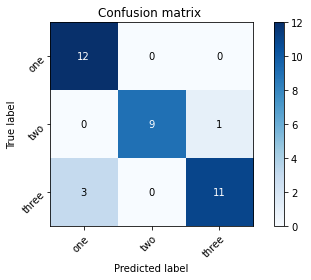

In [ ]:
print_results(calculate_metrics(y_test.values, y_ab), 'AdaBoost Ensemble')
cm = confusion_matrix(y_test, y_ab)
plot_confusion_matrix(cm, classes)

In [ ]:
#cross_validate(abclf, StratifiedKFold(10), X, y, classes)

In [ ]:
from sklearn.model_selection import cross_validate

In [ ]:
cv_results = cross_validate(abclf, X,y, cv=10)

In [ ]:
cv_results['test_score']

array([0.55555556, 1.        , 1.        , 0.94444444, 0.88888889,
       0.88888889, 0.72222222, 0.83333333, 1.        , 1.        ])

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
gbclf = GradientBoostingClassifier(n_estimators = 50)
gbclf.fit(X_train, y_train)

GradientBoostingClassifier(n_estimators=50)

In [ ]:
y_gb = gbclf.predict(X_test)

Results for GradientBoosting Ensemble
----
  Accuracy:  0.9444444444444444
  Precision: 0.9523809523809524
  Recall:    0.9523809523809524
  F1 score:  0.9487179487179486
  Mislabeled 2 out of 36




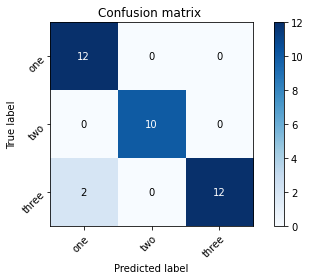

In [ ]:
print_results(calculate_metrics(y_test.values, y_gb), 'GradientBoosting Ensemble')
cm = confusion_matrix(y_test, y_gb)
plot_confusion_matrix(cm, classes)

In [ ]:
cv_results = cross_validate(gbclf, X,y, cv=10)

In [ ]:
cv_results['test_score']

array([0.72222222, 1.        , 0.88888889, 0.94444444, 0.83333333,
       0.94444444, 1.        , 0.88888889, 0.94117647, 0.94117647])